# imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from scipy.stats import weibull_min
import numpy as np
import pandas as pd
plt.style.use('seaborn')
%matplotlib inline

# Plausibility coefficient computation

## Step by step obtaining the coefficient

In [2]:
#1. get some data
from lifelines.datasets import load_waltons
from lifelines.utils import concordance_index

df = load_waltons()
#1.1 get a slice of non-censored controls
df = df[df.E != 0]

df.sample(5)

,T,E,group
4,19.0,1,miR-137
106,56.0,1,control
159,60.0,1,control
27,29.0,1,miR-137
109,56.0,1,control


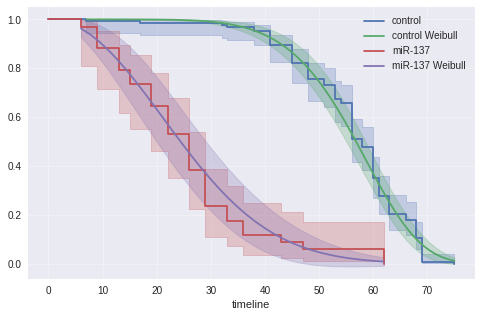

In [3]:
#2. Fit parameteric and non-parametric model to the case and control data
from lifelines import WeibullFitter, KaplanMeierFitter
from lifelines.datasets import load_waltons
from scipy.stats import kstest, cramervonmises

fig, ax = plt.subplots(1, 1, figsize=(8,5))
km = KaplanMeierFitter(alpha=0.05)
wf = WeibullFitter()

for name, grouped_df in df.groupby('group'):
    km.fit(grouped_df["T"], label=name)
    wf.fit(grouped_df["T"], label=name + ' Weibull')
    km.plot_survival_function(ax=ax)
    wf.plot_survival_function(ax=ax)
ax.grid(alpha=0.3) 

In [4]:
#3. Check that modelled distribution is "good" in terms of KS statistics
T = df[df.group=='control']['T']
wf = WeibullFitter().fit(T)
l, k = wf.lambda_, wf.rho_

def weibull_cdf(x):
    """
    null model for ks comparison
    x - support (must be > 0);
    l - scale parameter;
    k - shape parameter;
    returns: cdf on a given x
    """
    return 1 - np.exp(-(x / l)**k) 

#resulting statistics is some kind of distance between empirical and 
#theoretical distributions. This distance is bounded on [0, 1] interval
kstest(T, weibull_cdf)

KstestResult(statistic=0.12194206195446805, pvalue=0.048697288391741984)

In [5]:
#3.1 (KS) Then we can compute similarity (or plausibility) as just by subtracting
#the distance from 1
plausibility = 1 - kstest(T, weibull_cdf)[0]
plausibility

0.878057938045532

In [6]:
#3.2 (Cramer) Then we can compute similarity (or plausibility) as just by subtracting
#the distance from 1
tmp = cramervonmises(T, weibull_cdf)
plausibility = 1 - tmp.statistic
plausibility

0.7770839141456087

## several examples

In [7]:
from lifelines import WeibullFitter
from scipy.stats import kstest
import numpy as np

#make all in one function (portable to a script)
def compute_plausibility(T, E=None, stat=False, method='ks'):
    """
        Compute plausibility score that observed data are sampled from the
        chosen null distribution (Weubull in our case). The score is computed
        based on the Kolmogorov-Smirnov or Cramer-von-Mises statistics and ranged from -inf to 1,
        where 1 means full correspondence between data and null distribution;
        and 0 - the opposite.
        Vars:
        T::1d array - survival times vector;
        E::1d array - (optional) censoring vector
        stat::bool - whether return statistics or not along with
                        plausibility score
        returns -> float: plausibility score
    """
    kmf = KaplanMeierFitter().fit(T,)
    wf = WeibullFitter().fit(T, E)
    l, k = wf.lambda_, wf.rho_
    weibull_cdf = lambda x: 1 - np.exp(-(x / l)**k) 
    if method == 'ks':
        st, pval = kstest(T, weibull_cdf)
        plausibility = 1 / st
    elif method == 'cramer':
        tmp = cramervonmises(T, weibull_cdf)
        st, pval = tmp.statistic, tmp.pvalue
        plausibility = 1 / st
    elif method == 'brier':
        EDF = kmf.cumulative_density_['KM_estimate']
        CDF = weibull_cdf(kmf.timeline) 
        plausibility = 1 - np.mean((EDF - CDF) ** 2)
        st, pval = None, None
    elif method == 'r2':
        EDF = kmf.cumulative_density_['KM_estimate']
        CDF = weibull_cdf(kmf.timeline) 
        plausibility = np.corrcoef(EDF, CDF)[0,1]**2
        st, pval = None, None
    else:
        raise NotImplementedError()
    
    if stat:
        return plausibility, st, pval
    else:
        return plausibility

In [8]:
out = compute_plausibility(T, stat=True, method='cramer')
print("N samples:", T.shape[0])
print(f'Plausibility: {out[0]}; KS-statistics: {out[1]}; P-value: {out[2]}')

N samples: 122
Plausibility: 4.4859929967243355; KS-statistics: 0.2229160858543913; P-value: 0.22725632038790577


In [9]:
out = compute_plausibility(T, stat=False, method='brier')
print("N samples:", T.shape[0])
print(f'Plausibility: {out}')

N samples: 122
Plausibility: 0.9990161382188762


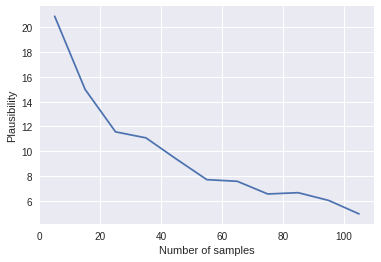

In [10]:
#case 1: small dataset
#we expect that plausibility will decrease (in average) with decreasing 
#the number of samples
n_samples = np.arange(5, 110, 10)
m_repeats = 10
pl_list = []
for n in n_samples:
    repeat = []
    for _ in range(m_repeats):
        control = df[(df.group == 'control') & (df.E == 1)].sample(n)
        pl, ks, p = compute_plausibility(control['T'], stat=True, method='cramer')
        repeat.append(pl)
    pl_list.append(np.mean(repeat))

plt.plot(n_samples, pl_list)
plt.xlabel('Number of samples')
plt.ylabel('Plausibility');

In [11]:
#case 2: repeat with case group
#one may see that similar values of plausibility do not guarantee similarity in
#p-values. We see here the case group having three times smaller number of 
#samples still exhibits high plausibility but large p-value
case = df[(df.group != 'control') & (df.E == 1)] 
print("N samples:", case.shape[0])
out = compute_plausibility(case['T'], stat=True, method='cramer')
print(f'Plausibility: {out[0]}; statistics: {out[1]}; P-value: {out[2]}')

N samples: 34
Plausibility: 13.57076606669515; statistics: 0.07368780768052302; P-value: 0.7323950652317901


<AxesSubplot:xlabel='timeline'>

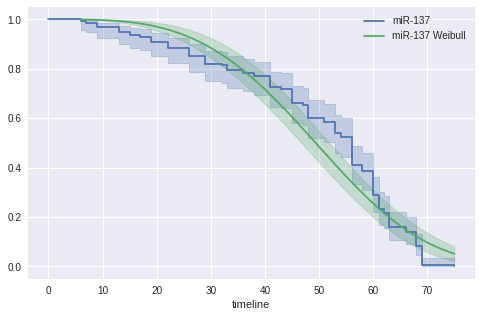

In [12]:
#case 3: mix case and controls
# first let's vizualize them. We still see quite a good fit but two regimes of
# the data are not caught by the model. How this manifests in terms of 
# plausibility?
fig, ax = plt.subplots(1, 1, figsize=(8,5))
km = KaplanMeierFitter(alpha=0.05)
wf = WeibullFitter()

km.fit(df["T"], label=name)
wf.fit(df["T"], label=name + ' Weibull')
km.plot_survival_function(ax=ax)
wf.plot_survival_function(ax=ax)

In [13]:
# we see that plausibility decreased. Not dramatically, at first glance, but
# in comparison with previous two this decrease is substantial.
print("N samples:", df.shape[0])
out = compute_plausibility(df['T'], stat=True, method='cramer')
print(f'Plausibility: {out[0]}; statistics: {out[1]}; P-value: {out[2]}')

N samples: 156
Plausibility: 0.9674584494381523; statistics: 1.033636122130874; P-value: 0.0020073375017142236


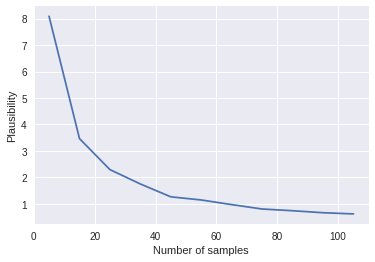

In [14]:
# case 4: check plausibility for Normal prior

#we expect that plausibility will decrease (in average) with decreasing 
#the number of samples
n_samples = np.arange(5, 110, 10)
m_repeats = 10
pl_list = []
for n in n_samples:
    repeat = []
    for _ in range(m_repeats):
        control = np.concatenate([np.abs(np.random.randn(n) * 3 + 3), np.abs(np.random.randn(n) * 3 + 20)])
        pl, ks, p = compute_plausibility(control, stat=True, method='cramer')
        repeat.append(pl)
    pl_list.append(np.mean(repeat))

plt.plot(n_samples, pl_list)
plt.xlabel('Number of samples')
plt.ylabel('Plausibility');

**Conclusion:** $KS$-stat show the relative distance between the data and fitted null model. Plausibility = $1 - KS$, therefore, can be a useful measure to compare the shapes of data curve and model curve. At the same time, P-value is extremely sensitive to a number of samples in data, and cannot be interpreted straightforwardly in case of large number of samples. But it is still useful when we have small number of samples ($\le$30) and can help us to reject null hypothesis about equality of two distributions.

 - вставить в статью короткий параграф про правдоподобие данных как пришедших из правильного распределения (@shappiron)
 - дать Дмитрию доступ к текущему коду сервера и обсудить с ним как вставить вот немедленно какой то baby step по просчету правдоподобности данных (@imhelle  & @shappiron ) 
 - выбрать куда мы шлем (@imhelle  @shappiron  @Nikolai_Nemirovich_Danchenko  список Nature Aging ? Aging Cell ? ) представить статью в редакцию (Leon)  
 - выбрать куда мы шлем описание формата (@imhelle  @Nikolai_Nemirovich_Danchenko @shappiron  список вторичных чисто Data / journals) и послать (Леон) 

# Real Data Examples

# defs

In [56]:
def prepare_plot(title='Title'):
    fig, ax = plt.subplots(figsize=(25,10))
    #sns.set(font_scale=1.3, rc={'axes.facecolor':'w', 'figure.facecolor':'#eee'}) #, rc={'axes.facecolor':'#eee'}, 'figure.facecolor':'cornflowerblue'
    sns.set_style("whitegrid")
    sns.set_context("paper", font_scale=3.1)
    ax.axhline(50, ls='--', color='#ddd')
    ax.set_title(title,fontsize=21, y=1.05)
    ax.set_xlabel("Lifespan (days)",fontsize=30)
    ax.set_ylabel("Survival Rate (%)",fontsize=30)
    return fig, ax

def prepare_data(data):
    data = data.splitlines()
    return np.array(data, dtype=float).tolist()

def convert_to_lifetimes(x, y, n):
    coef = 100 / n
    y_true = np.array(y) // coef * coef
    number_of_died = np.abs(np.diff(y_true) / coef)
    niter = np.concatenate([np.array([0]), number_of_died])

    lifetimes = []
    for i, d in enumerate(niter):
        if d != 0:
            lifetimes = lifetimes + [x[i]] * int(np.round(d))
    if len(lifetimes) != n:
        print('Warning: Computed number of lifetimes != n')
    #assert len(lifetimes) == n, 'Something wrong!'
    return lifetimes

# collecting data

### experiments

In [16]:
# 10.1007/s10522-007-9100-z  -----  TC feeding at the age of the 13th month - e C57BL/6JHsd mice were obtained from HarlanSpraque Dawley (Indianapolis, ID) +++

curcumin_data_control = {
  'x': [12.97493, 16.08407, 18.01475, 19.0177, 21.9764, 22.97935, 23.93215, 24.98525, 25.93805, 26.99115, 28.01917, 28.97198, 29.92478, 32.88348, 33.88643, 34.88938],
  'y': [100, 100, 99.07162, 92.04244, 89.65517, 81.56499, 79.5756, 69.23077, 65.64987, 43.8992, 33.81963, 29.17772, 21.61804, 10.2122, 5.83554, 1.72414],        
  'n': 50
} 

curcumin_data_experiment = {
  'x' : [13.02507, 18.9174, 20.02065, 20.99853, 23.93215, 24.96018, 25.96313, 27.01622, 28.92183, 30.02507, 30.97788, 31.98083, 32.93363, 33.88643, 35.96755, 37.02065],
  'y': [100, 100, 96.02122, 91.64456, 90.45093, 85.94164, 79.97347, 59.54907, 49.73475, 40.3183, 28.51459, 22.14854, 14.58886, 5.70292, 2.12202, 0.26525],
  'n': 50
} 

curcumin_data_control['x'] = [i * 30.5 for i in curcumin_data_control['x']] # months to days
curcumin_data_experiment['x'] = [i * 30.5 for i in curcumin_data_experiment['x']]

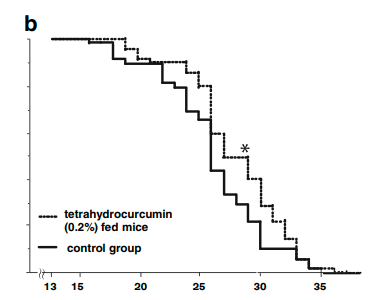

In [17]:
# 10.1111/acel.13060 - C57BL/6J from SPF Biotechnology Co., Ltd, Beijng, China +++

berberine_control = {
  'x' : [3.94144, 399.66216, 446.95946, 457.20721, 517.11712, 530.51802, 545.4955, 550.22523, 553.37838, 562.83784, 575.45045, 583.33333, 598.31081, 614.07658, 654.27928, 670.83333, 675.56306, 680.29279, 706.30631, 707.88288, 709.45946],
  'y' : [100.35587, 100.17794, 95.37367, 91.28114, 86.121, 81.6726, 77.04626, 72.59786, 67.97153, 63.879, 59.07473, 54.62633, 50.17794, 45.5516, 36.29893, 32.02847, 27.75801, 22.7758, 17.97153, 9.25267, 0.17794],
  'n' : 22
}

berberine_experiment = {
  'x' : [3.94144, 429.61712, 472.97297, 527.36486, 540.76577, 549.43694, 584.12162, 594.36937, 642.45495, 647.97297, 670.83333, 677.92793, 693.69369, 696.84685, 703.15315, 707.09459, 711.82432, 723.64865, 731.53153, 736.26126, 745.72072, 755.96847, 757.54505],
  'y' : [100.35587, 100.17794, 95.5516, 91.45907, 86.29893, 82.02847, 76.86833, 72.59786, 68.14947, 63.879, 59.07473, 54.62633, 50.53381, 45.90747, 41.1032, 36.6548, 32.20641, 27.58007, 23.30961, 18.3274, 13.879, 9.07473, 0.71174],
  'n' : 22
}


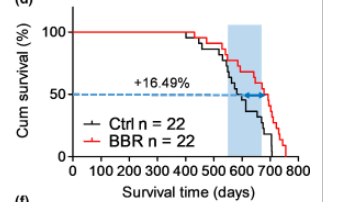

In [18]:
# https://www.nature.com/articles/s41467-021-23545-7 - C57BL/6JOlaHsd +++

sirt_control = {
  'x' : [13.74046, 287.0229, 323.66412, 392.36641, 538.9313, 563.35878, 586.25954, 603.05344, 615.26718, 622.90076, 629.00763, 629.00763, 633.58779, 641.22137, 653.43511, 656.48855, 674.80916, 677.8626, 696.18321, 700.76336, 712.9771, 725.19084, 734.35115, 745.03817, 772.51908, 793.89313, 796.94656, 806.10687, 815.26718, 822.90076, 827.48092, 836.64122, 845.80153, 879.38931, 902.29008, 906.87023, 919.08397, 934.35115, 986.25954, 1018.32061, 1051.9084, 1077.8626],
  'y' : [100.6993, 100.52448, 98.6014, 94.40559, 92.65734, 90.55944, 88.98601, 86.71329, 85.13986, 82.86713, 81.29371, 79.1958, 77.27273, 75.34965, 73.6014, 71.15385, 69.40559, 67.65734, 65.73427, 61.88811, 55.94406, 54.1958, 52.27273, 48.25175, 46.5035, 44.40559, 39.33566, 36.88811, 34.44056, 32.69231, 30.94406, 28.67133, 25, 23.25175, 21.67832, 19.75524, 17.65734, 15.38462, 9.79021, 7.86713, 5.94406, 2.0979],
  'n' : 52
}

sirt_experiment = {
  'x' : [13.74046, 561.83206, 590.83969, 615.26718, 647.32824, 670.22901, 671.75573, 691.60305, 714.50382, 722.1374, 770.99237, 775.57252, 806.10687, 810.68702, 833.58779, 850.38168, 853.43511, 862.59542, 877.8626, 891.60305, 899.23664, 911.45038, 931.29771, 937.40458, 948.0916, 980.15267, 987.78626, 989.31298, 993.89313, 1001.52672, 1003.05344, 1012.21374, 1015.26718, 1021.37405, 1025.9542, 1051.9084, 1059.54198, 1073.28244, 1080.91603, 1088.54962, 1105.34351, 1166.41221, 1184.73282],
  'y' : [100.6993, 100.17483, 98.42657, 96.5035, 94.23077, 90.73427, 88.11189, 86.36364, 84.26573, 82.51748, 80.41958, 78.67133, 76.3986, 74.82517, 72.55245, 70.8042, 69.23077, 66.95804, 65.03497, 62.93706, 59.44056, 54.8951, 53.14685, 49.3007, 47.2028, 45.27972, 41.43357, 39.68531, 37.76224, 35.66434, 32.34266, 29.54545, 25.87413, 23.77622, 20.27972, 17.83217, 15.03497, 12.06294, 10.13986, 8.04196, 5.94406, 4.02098, 2.0979],
  'n' : 51
}


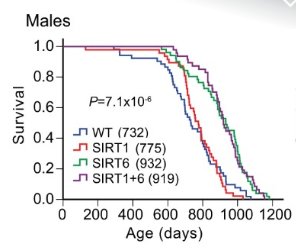

In [19]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4996648/ - PMID: 27549339 males - C57BL6/JNia - National Institute on Aging Aged Rodent Colony. ++++      

rapa_control = {
  'x' : [7.0922, 679.43262, 760.28369, 771.63121, 792.9078, 842.55319, 846.80851, 852.48227, 924.8227, 927.65957, 951.77305, 964.53901, 1001.41844, 1028.36879, 1032.62411, 1143.26241, 1177.30496, 1234.04255, 1235.46099],
  'y': [100, 99.71751, 94.49153, 89.12429, 77.9661, 72.31638, 66.38418, 61.15819, 55.79096, 49.71751, 44.49153, 38.84181, 33.05085, 27.68362, 22.0339, 16.38418, 10.73446, 5.50847, 0.42373],
  'n':18
}

rapa_experiment = {
    'x' : [8.50202, 756.68016, 807.69231, 851.61943, 930.97166, 953.64372, 969.23077, 994.73684, 1054.25101, 1082.59109, 1101.01215, 1106.68016, 1116.59919, 1259.7166, 1286.63968, 1401.417, 1401.417],
    'y' : [100.42433, 100.14144, 95.0495, 88.82603, 82.60255, 76.80339, 70.8628, 64.92221, 58.69873, 47.38331, 41.44272, 35.64356, 23.76238, 17.68034, 12.02263, 6.08204, 1.13154],
    'n':17
}


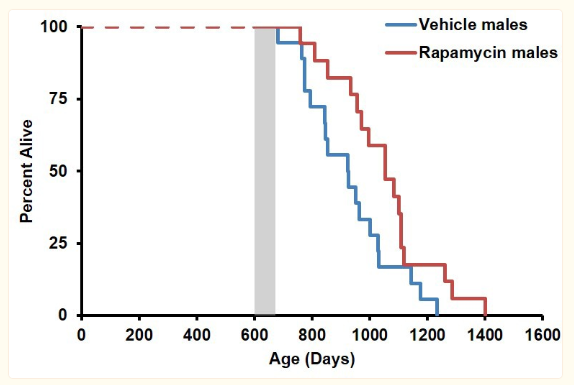

### controls from other papers

In [20]:
# PMID: 28877458 +++

keto_control = {
  'x' : [12.68982, 13.29341, 14.58683, 14.87425, 15.56407, 17.77725, 19.78922, 20.30659, 20.6515, 22.37605, 23.41078, 23.75569, 24.61796, 25.07784, 25.9976, 26.22754, 26.37126, 27.46347, 27.89461, 28.29701, 28.61317, 28.9006, 29.36048, 29.56168, 30.28024, 30.7976, 30.97006, 32.32096, 32.72335, 32.92455, 33.12575, 33.26946, 34.4479, 34.99401, 35.28144, 35.56886, 35.68383],
  'y' : [100, 98.18482, 96.53465, 95.21452, 93.23432, 91.74917, 90.09901, 88.11881, 85.31353, 83.33333, 81.51815, 80.19802, 78.54785, 76.56766, 75.41254, 70.62706, 68.64686, 66.9967, 64.68647, 60.89109, 57.42574, 55.11551, 50.9901, 49.33993, 47.0297, 45.37954, 43.23432, 40.92409, 38.11881, 36.30363, 33.82838, 31.35314, 19.63696, 15.84158, 11.71617, 8.25083, 3.46535],
  'n' : 61
}

keto_control['x'] = [i * 30.5 for i in keto_control['x']] # months to days

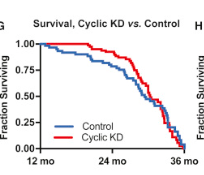

In [21]:
# https://pubmed.ncbi.nlm.nih.gov/24409289/ PMID: 24409289 

rapa2_control = {
  'x' : [11.55676, 13.34054, 18.3027, 18.98378, 21.70811, 22.12973, 23.52432, 23.65405, 23.84865, 24.10811, 24.3027, 24.75676, 25.21081, 25.40541, 25.47027, 25.72973, 25.89189, 26.11892, 26.31351, 26.37838, 26.92973, 26.92973, 27.38378, 27.41622, 27.67568, 28.12973, 28.35676, 28.51892, 28.64865, 30.17297, 30.65946, 30.75676, 32.08649, 32.34595, 32.41081, 32.73514, 33.44865, 34.64865, 36.04324],
  'y' : [97.51825, 95.0365, 92.70073, 90.80292, 87.44526, 85.25547, 82.91971, 81.16788, 78.24818, 75.0365, 72.9927, 70.80292, 67.88321, 65.10949, 62.18978, 59.56204, 56.93431, 54.45255, 51.82482, 49.19708, 45.69343, 42.91971, 40.87591, 38.24818, 35.32847, 32.84672, 30.51095, 27.88321, 25.54745, 22.62774, 20.58394, 17.66423, 15.47445, 12.40876, 9.78102, 7.73723, 4.81752, 2.48175, 0.14599],
  'n' : 40
}

rapa2_control['x'] = [i * 30.5 for i in rapa2_control['x']] # months to days

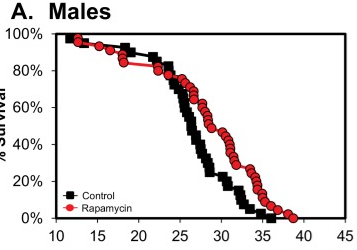

In [72]:
#  https://www.ihmc.us/wp-content/uploads/2017/10/Ramsey-Mouse-Longevity-Cell-Metab-9-17.pdf - control males C57BL/6 

diet_control = {
  'x': [616.9697, 650.90909, 661.81818, 682.42424, 696.9697, 699.39394, 718.78788, 750.30303, 772.12121, 806.06061, 826.66667, 830.30303, 835.15152, 844.84848, 849.69697, 855.75758, 856.9697, 875.15152, 878.78788, 884.84848, 893.33333, 916.36364, 918.78788, 924.84848, 935.75758, 949.09091, 981.81818, 985.45455, 986.66667, 990.30303, 991.51515, 1007.27273, 1009.69697, 1019.39394, 1037.57576, 1073.93939, 1096.9697, 1103.0303, 1166.06061, 1229.09091],
  'y' : [98.23322, 96.11307, 94.87633, 93.63958, 91.51943, 87.98587, 86.0424, 84.4523, 79.15194, 74.91166, 72.79152, 70.31802, 67.84452, 65.5477, 63.42756, 60.95406, 57.95053, 56.36042, 51.41343, 49.11661, 47.17314, 45.053, 42.75618, 39.75265, 37.80919, 35.15901, 33.5689, 31.27208, 28.79859, 26.32509, 23.32155, 21.73145, 19.43463, 16.4311, 12.01413, 9.71731, 7.59717, 4.947, 2.4735, 0.88339],
  'n' : 43
}


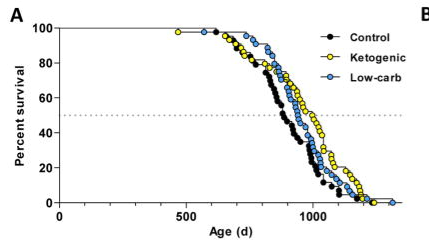

In [23]:
# https://sci-hub.hkvisa.net/10.1007/s11357-018-0039-6 - control males C57BL/6 

thioredoxin_control = {
  'x' : [15.82734, 394.2446, 420.14388, 437.41007, 470.5036, 487.76978, 555.39568, 587.05036, 687.76978, 696.40288, 736.69065, 761.15108, 764.02878, 807.19424, 811.51079, 817.26619, 834.53237, 831.65468, 847.48201, 853.23741, 854.67626, 886.33094, 897.84173, 906.47482, 928.05755, 941.00719, 981.29496, 987.05036, 1038.84892, 1051.79856, 1089.20863, 1109.35252, 1142.44604, 1164.02878],
  'y' : [100.31104, 97.0451, 93.62364, 90.51322, 87.4028, 84.4479, 81.95956, 78.5381, 75.73872, 72.31726, 69.05132, 66.71851, 63.60809, 60.80871, 57.38725, 53.96579, 51.63297, 47.74495, 45.25661, 42.30171, 39.19129, 36.08087, 32.97045, 30.32659, 27.3717, 23.79471, 20.68429, 17.41835, 14.77449, 11.50855, 9.17574, 5.9098, 2.9549, -0.15552]
}


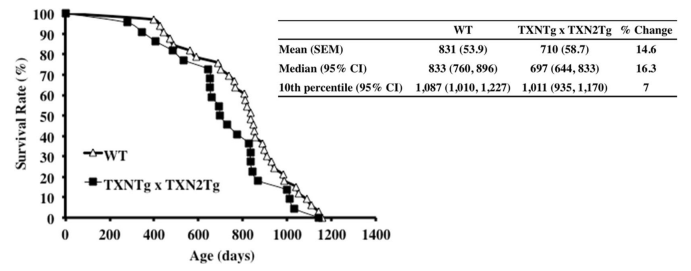

In [24]:
# https://www.cell.com/cell-metabolism/fulltext/S1550-4131(20)30417-4 - control males C57BL/6 

akg_control = {
  'x' : [16.16434, 25.91318, 26.21085, 27.10388, 27.15349, 27.97209, 28.76589, 29.43566, 30.32868, 30.47752, 30.99845, 31.49457, 31.69302, 31.84186, 32.95814, 33.15659, 33.50388, 33.67752, 35.04186, 35.41395, 35.48837, 36.48062, 36.90233],
  'y' : [100.74442, 96.77419, 96.27792, 91.81141, 87.34491, 82.87841, 78.66005, 74.19355, 73.44913, 68.73449, 63.77171, 59.05707, 54.83871, 49.62779, 44.16873, 34.98759, 30.27295, 25.06203, 20.59553, 15.38462, 10.42184, 5.45906, 0.99256],
  'n' : 24
}

akg_control['x'] = [i * 30.5 for i in akg_control['x']] # months to days


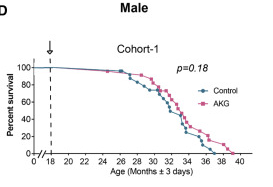

In [25]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8991228/ PMID: 35393401

prot_restr_control = {
  'x' : [0.16416, 6.48427, 11.03967, 11.20383, 16.70315, 17.8933, 19.53488, 21.01231, 21.75103, 22.0383, 23.02326, 23.72093, 24.09029, 24.37756, 24.50068, 26.75787, 27.33242, 27.57866, 28.07114, 28.27633, 28.39945, 28.76881, 29.46648, 29.83584, 30.45144, 31.39535, 32.25718, 32.66758, 33.81669, 33.81669],
  'y' : [100.51458, 100.17153, 97.08405, 93.99657, 90.22298, 86.4494, 83.53345, 80.10292, 76.84391, 73.75643, 70.15437, 66.89537, 60.37736, 53.5163, 49.57118, 47.34134, 43.39623, 40.13722, 36.87822, 33.61921, 30.01715, 26.75815, 22.98456, 19.3825, 16.63808, 13.03602, 9.60549, 6.17496, 3.43053, 0.34305]
}

prot_restr_control['x'] = [i * 30.5 for i in prot_restr_control['x']] # months to days

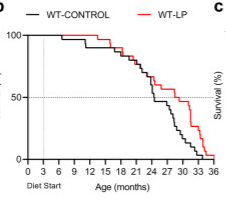

In [73]:
# https://www.biorxiv.org/content/10.1101/2019.12.20.884452v1.full#F6 PMID: 32934233

frailty_control = {
  'x' : [21.11976, 22.72455, 23.41916, 24.13772, 25.31138, 27.63473, 27.94611, 28.16168, 28.88024, 29.98204, 30.17365, 30.31737, 30.53293, 31.22754, 31.49102, 34.1976, 34.48503, 34.98802, 35.65868, 36.28144, 36.80838, 37.23952, 37.28743],
  'y' : [99.84733, 100.30534, 95.87786, 91.75573, 87.78626, 83.35878, 79.23664, 74.96183, 70.53435, 66.87023, 62.44275, 58.32061, 54.35115, 46.10687, 37.70992, 33.89313, 25.64885, 21.22137, 16.94656, 13.12977, 8.70229, 4.8855, 0.30534],
  'n' : 24
}

frailty_control['x'] = [i * 30.5 for i in frailty_control['x']] # months to days

In [74]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9262309/#SD1 35511946
x = """0
468.50649
493.83117
542.53247
548.37662
553.24675
569.80519
575.64935
580.51948
586.36364
606.81818
641.88312
657.46753
670.12987
674.02597
676.94805
694.48052
726.62338
731.49351
746.1039
771.42857
791.88312
818.18182
820.12987
828.8961
878.57143
888.31169
895.12987
900
902.92208
910.71429
930.19481
948.7013
974.02597
989.61039
1001.2987
1058.76623
1067.53247
1103.57143
1107.46753
"""
y = """100
99.58948
97.51355
95.16082
92.91087
90.84106
88.40804
86.15809
83.72857
81.7484
79.31421
77.59507
75.16234
72.64056
68.41277
66.43348
63.82031
62.01211
59.49267
57.15016
54.80444
52.81989
48.13574
43.63876
41.65771
37.14642
34.62551
32.55512
30.30546
28.14631
21.39937
18.96548
16.80166
14.45594
12.20306
9.86143
7.68593
5.16532
3.44588
0
"""
circad_control = {
  'x' : prepare_data(x),
  'y' : prepare_data(y),
  'n' : 43
}

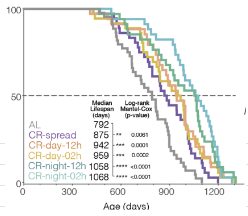

In [75]:
# 20370440
x = """45.43046
52.71523
54.56954
59.60265
60.66225
62.91391
63.57616
66.88742
67.94702
72.71523
74.03974
77.74834
78.4106
82.78146
84.76821
86.88742
86.88742
87.81457
90.46358
93.90728
95.49669
96.42384
99.7351
101.0596
102.11921
102.91391
104.23841
105.96026
106.88742
108.74172
110.06623
111.92053
116.02649
118.6755
120
123.44371
124.90066
125.96026
127.41722
127.81457
129.13907
129.80132
131.12583
132.98013
134.17219
134.17219
134.70199
135.89404
136.95364
139.86755
143.84106
147.01987
148.07947
161.19205
"""
y = """100
100
96.38989
96.38989
94.76534
94.58484
91.51625
91.24549
89.8917
90.0722
86.6426
86.8231
85.19856
85.19856
81.94946
81.94946
81.94946
80.1444
80.1444
75.09025
74.81949
71.84116
71.29964
68.41155
68.05054
66.42599
66.6065
61.91336
61.55235
55.23466
55.05415
44.76534
44.76534
37.00361
36.46209
28.51986
28.33935
26.80505
26.26354
24.90975
24.45848
23.2852
22.92419
18.68231
18.41155
18.41155
14.98195
14.80144
13.1769
12.99639
6.6787
6.49819
3.4296
3.2491
"""
chinese_control = {
  'x' : prepare_data(x),
  'y' : prepare_data(y),
  'n' : 54
}
chinese_control['x'] = [i * 7 for i in chinese_control['x']] # weeks to days

# Analyze

In [68]:
NAMES = ['Curcumin control', 'Curcumin experiment',
         'Berberine control', 'Berberine experiment',
         'Sirtuin control', 'Sirtuin experiment',
         'Rapamycin control', 'Rapamycin experiment',
         'Keto control', 'Rapamycin2 control',
         'Diet control', 'AKG control',
         'Frailty control', 'Chinese control', 
         'Circad control']
EXPERIMENTS = [curcumin_data_control, curcumin_data_experiment,
               berberine_control, berberine_experiment,
               sirt_control, sirt_experiment,
               rapa_control, rapa_experiment,
               keto_control, rapa2_control,
               diet_control, akg_control,
               frailty_control, chinese_control, 
               circad_control]

df = pd.DataFrame()
for name, experiment in zip(NAMES, EXPERIMENTS):
    x = experiment['x']
    y = experiment['y']
    n = experiment['n']
    T = convert_to_lifetimes(x, y, n)  
    pl, st, pval = compute_plausibility(T, E=None, stat=True, method='cramer')
    brier = compute_plausibility(T, stat=False, method='brier')
    r2 = compute_plausibility(T, stat=False, method='r2')
    df = df.append({'Name':name, 'Plausibility':1/st, 'n':n, 'Pvalue':pval, 'Brier':brier, 'R2':r2}, ignore_index=True)

uniform_pl = []
uniform_br = []
uniform_r2 = []
for _ in range(5):
    uniform_dummy_control = np.random.uniform(1, 100, 50)
    pl, st, pval = compute_plausibility(uniform_dummy_control, E=None, stat=True, method='cramer')
    brier = compute_plausibility(uniform_dummy_control, stat=False, method='brier')
    r2 = compute_plausibility(uniform_dummy_control, stat=False, method='r2')
    uniform_pl.append(st)
    uniform_br.append(brier)
    uniform_r2.append(r2)
df = df.append({'Name':'Uniform Dummy data', 'Plausibility':1/np.mean(uniform_pl), 
                'n':uniform_dummy_control.shape[0], 'Pvalue':pval, 'Brier':np.mean(uniform_br), 'R2':np.mean(uniform_r2)}, ignore_index=True)

weibull_pl = []
weibull_br = []
weibull_r2 = []
for _ in range(5):
    weibull_dummy_control = weibull_min.rvs(2, loc=0, scale=5, size=50)
    pl, st, pval = compute_plausibility(weibull_dummy_control, E=None, stat=True, method='cramer')
    brier = compute_plausibility(weibull_dummy_control, stat=False, method='brier')
    r2 = compute_plausibility(weibull_dummy_control, stat=False, method='r2')
    weibull_pl.append(st)
    weibull_br.append(brier)
    weibull_r2.append(r2)
df = df.append({'Name':'Weibull Dummy data', 'Plausibility':1/np.mean(weibull_pl), 
                'n':weibull_dummy_control.shape[0], 'Pvalue':pval, 'Brier':np.mean(weibull_br), 'R2':np.mean(weibull_r2)}, ignore_index=True)

df.index = df.index + 1
df['Plausibility'] = np.round(df['Plausibility'], 1)
df['Pvalue'] = np.round(df['Pvalue'], 2)
df['Brier'] = np.round(df['Brier'], 4)
df['R2'] = np.round(df['R2'], 4)
df['n'] = df['n'].astype(int)

df

,Name,Plausibility,n,Pvalue,Brier,R2
1,Curcumin control,6.2,50,0.36,0.9960,0.9795
2,Curcumin experiment,13.0,50,0.71,0.9977,0.9902
3,Berberine control,9.8,22,0.58,0.9951,0.9711
4,Berberine experiment,8.1,22,0.49,0.9948,0.9544
5,Sirtuin control,14.7,52,0.76,0.9985,0.9866
6,Sirtuin experiment,12.7,51,0.70,0.9986,0.9861
7,Rapamycin control,15.7,18,0.80,0.9948,0.9688
8,Rapamycin experiment,10.6,17,0.62,0.9938,0.9585
9,Keto control,5.5,61,0.30,0.9976,0.9775
10,Rapamycin2 control,11.9,40,0.67,0.9975,0.9757


In [76]:
NAMES = ['Curcumin control', 'Curcumin experiment',
         'Berberine control', 'Berberine experiment',
         'Sirtuin control', 'Sirtuin experiment',
         'Rapamycin control', 'Rapamycin experiment',
         'Keto control', 'Rapamycin2 control',
         'Diet control', 'AKG control',
         'Frailty control', 
         'Chinese control', 
         'Circad control']
EXPERIMENTS = [curcumin_data_control, curcumin_data_experiment,
               berberine_control, berberine_experiment,
               sirt_control, sirt_experiment,
               rapa_control, rapa_experiment,
               keto_control, rapa2_control,
               diet_control, akg_control,
               frailty_control, 
               chinese_control, 
               circad_control]

In [77]:
import json
data = dict(zip(NAMES, EXPERIMENTS))

with open('data/data.json', 'w') as f:
    json.dump(data, f)

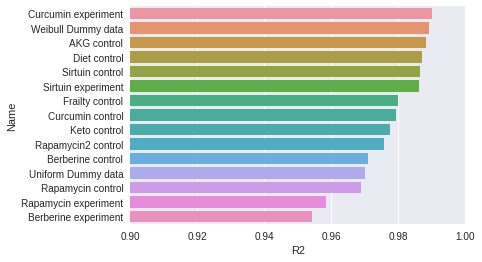

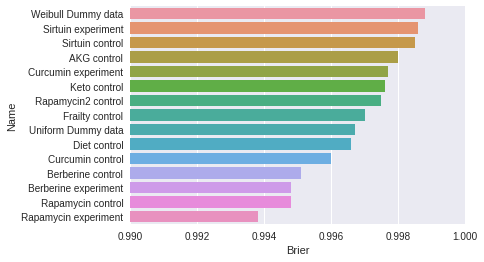

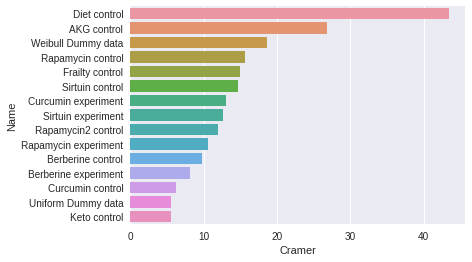

In [31]:
df_sort = df.sort_values('R2', ascending=False)
sns.barplot(y='Name', x='R2', data=df_sort,)
plt.xlim([0.9,1.0])
plt.show()

df_sort = df.sort_values('Brier', ascending=False)
sns.barplot(y='Name', x='Brier', data=df_sort,)
plt.xlim([0.99,1.0])
plt.show()

df_sort = df.sort_values('Plausibility', ascending=False)
sns.barplot(y='Name', x='Plausibility', data=df_sort,);
plt.xlabel('Cramer');

In [32]:
df.to_csv('plausible.csv')

In [33]:
df[['Plausibility', 'Brier', 'R2']].corr()

,Plausibility,Brier,R2
Plausibility,1.000000,0.196241,0.478073
Brier,0.196241,1.000000,0.846432
R2,0.478073,0.846432,1.000000


# plot

## separately

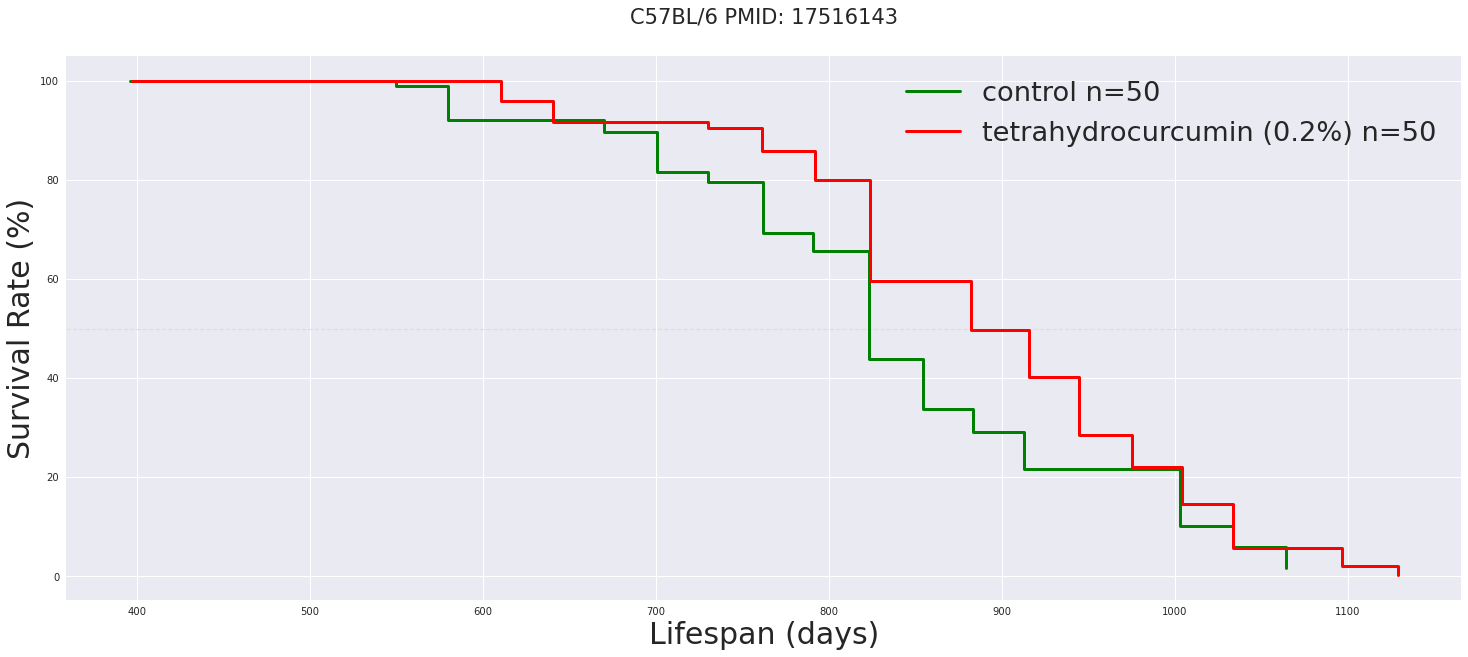

In [34]:
fig, ax = prepare_plot('C57BL/6 PMID: 17516143')

ax= sns.lineplot(data=curcumin_data_control, y='y', x='x', color='g', label= 'control n=50', drawstyle='steps-post', linewidth = 3)
ax1= sns.lineplot(data=curcumin_data_experiment, y='y', x='x', color='r', label= 'tetrahydrocurcumin (0.2%) n=50', drawstyle='steps-post', linewidth = 3)

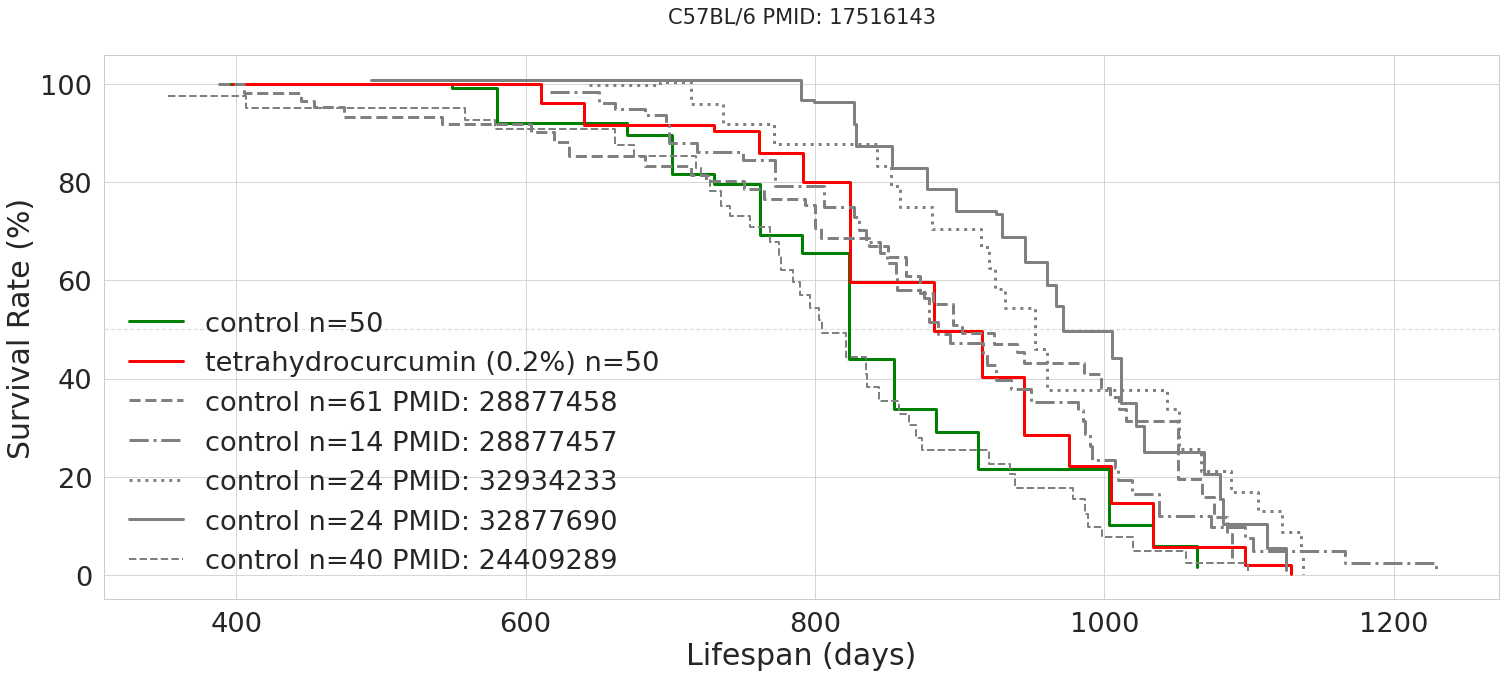

In [35]:
fig, ax = prepare_plot('C57BL/6 PMID: 17516143')

ax= sns.lineplot(data=curcumin_data_control, y='y', x='x', color='g', label= 'control n=50', drawstyle='steps-post', linewidth = 3)
ax1= sns.lineplot(data=curcumin_data_experiment, y='y', x='x', color='r', label= 'tetrahydrocurcumin (0.2%) n=50', drawstyle='steps-post', linewidth = 3)

ax2 = sns.lineplot(data=keto_control, y='y', x='x', color='gray', label= 'control n=61 PMID: 28877458', ls='--', drawstyle='steps-post', linewidth = 3)
ax3 = sns.lineplot(data=diet_control, y='y', x='x', color='gray', label= 'control n=14 PMID: 28877457', ls='-.', drawstyle='steps-post', linewidth = 3)
ax4 = sns.lineplot(data=frailty_control, y='y', x='x', color='gray', label= 'control n=24 PMID: 32934233', ls=':', drawstyle='steps-post', linewidth = 3)
ax5 = sns.lineplot(data=akg_control, y='y', x='x', color='gray', label= 'control n=24 PMID: 32877690', drawstyle='steps-post', linewidth = 3)
ax6 = sns.lineplot(data=rapa2_control, y='y', x='x', color='gray', label= 'control n=40 PMID: 24409289', ls='--', drawstyle='steps-post', linewidth = 2)

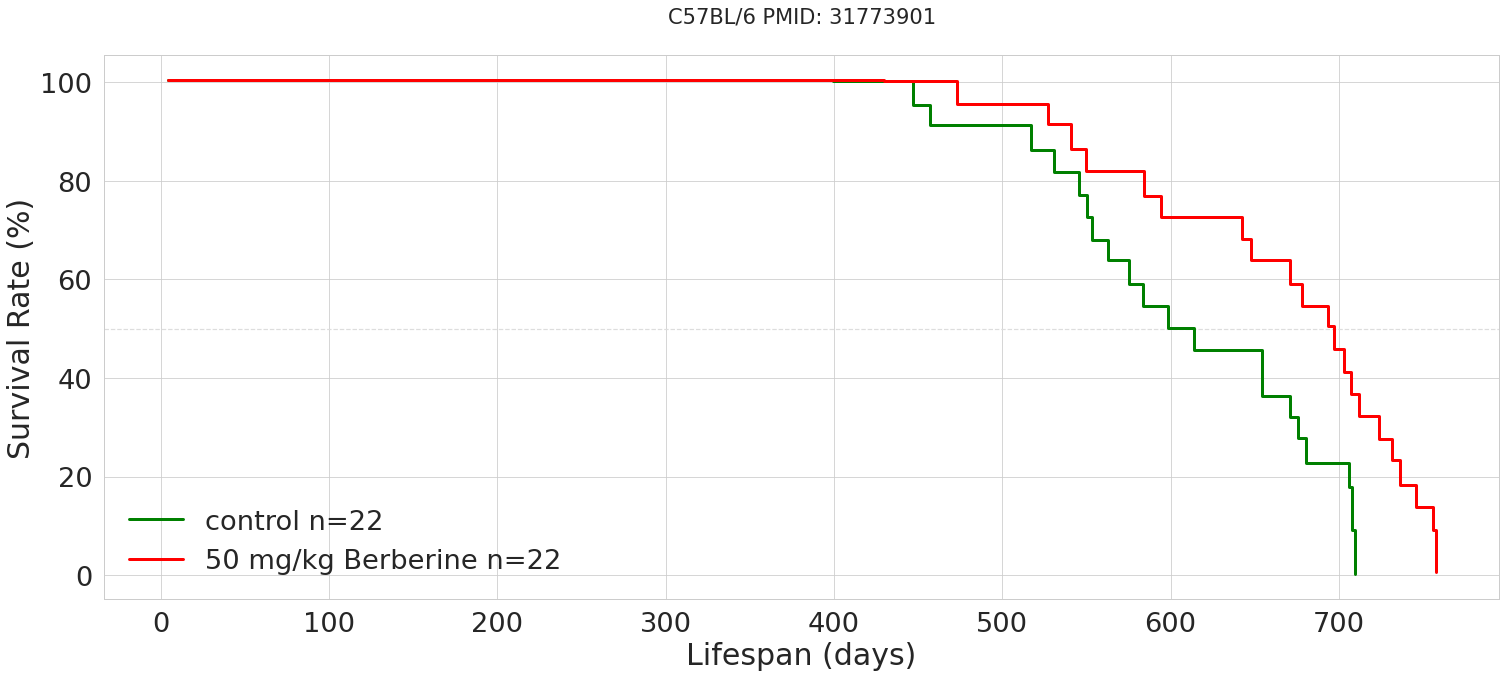

In [36]:
fig, ax = prepare_plot('C57BL/6 PMID: 31773901')

ax= sns.lineplot(data=berberine_control, y='y', x='x', color='g', label= 'control n=22', drawstyle='steps-post', linewidth = 3)
ax1= sns.lineplot(data=berberine_experiment, y='y', x='x', color='r', label= '50 mg/kg Berberine n=22', drawstyle='steps-post', linewidth = 3)

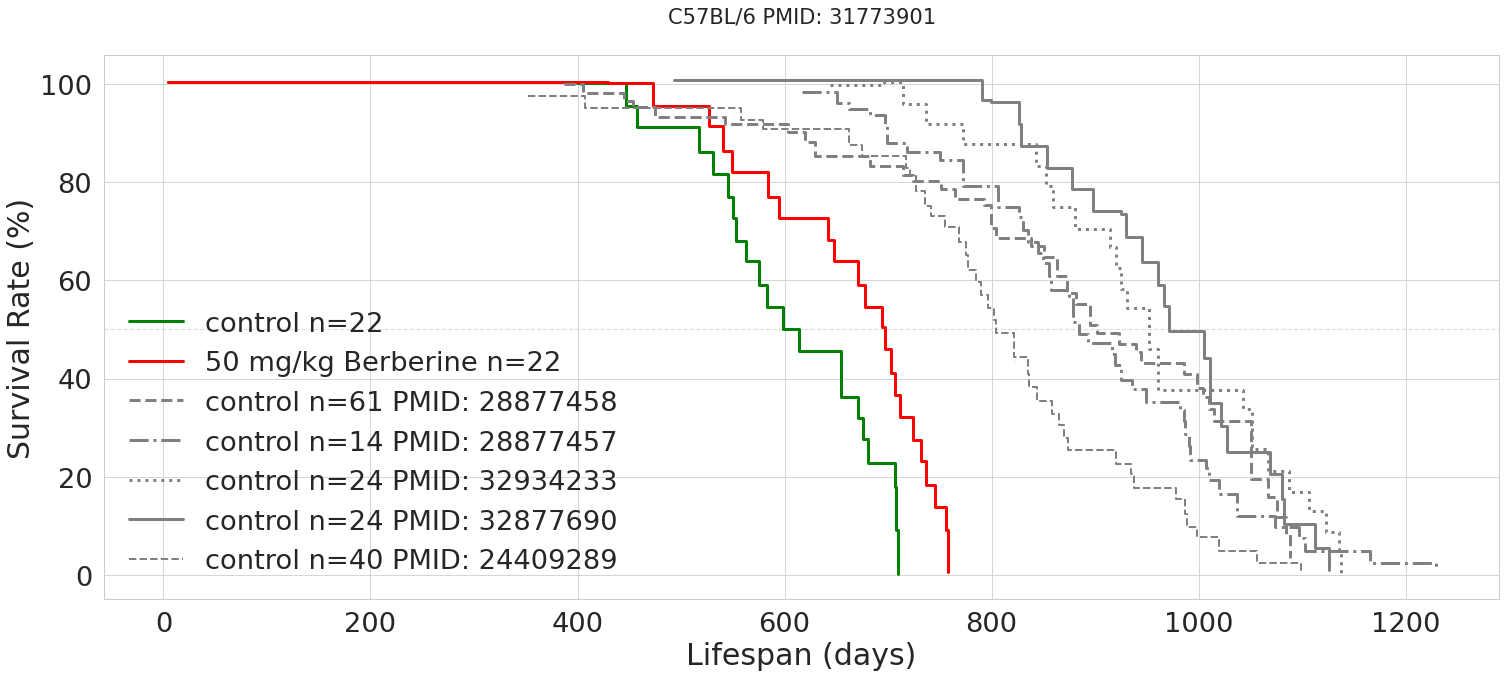

In [37]:
fig, ax = prepare_plot('C57BL/6 PMID: 31773901')

ax= sns.lineplot(data=berberine_control, y='y', x='x', color='g', label= 'control n=22', drawstyle='steps-post', linewidth = 3)
ax1= sns.lineplot(data=berberine_experiment, y='y', x='x', color='r', label= '50 mg/kg Berberine n=22', drawstyle='steps-post', linewidth = 3)

ax2 = sns.lineplot(data=keto_control, y='y', x='x', color='gray', label= 'control n=61 PMID: 28877458', ls='--', drawstyle='steps-post', linewidth = 3)
ax3 = sns.lineplot(data=diet_control, y='y', x='x', color='gray', label= 'control n=14 PMID: 28877457', ls='-.', drawstyle='steps-post', linewidth = 3)
ax4 = sns.lineplot(data=frailty_control, y='y', x='x', color='gray', label= 'control n=24 PMID: 32934233', ls=':', drawstyle='steps-post', linewidth = 3)
ax5 = sns.lineplot(data=akg_control, y='y', x='x', color='gray', label= 'control n=24 PMID: 32877690', drawstyle='steps-post', linewidth = 3)
ax6 = sns.lineplot(data=rapa2_control, y='y', x='x', color='gray', label= 'control n=40 PMID: 24409289', ls='--', drawstyle='steps-post', linewidth = 2)

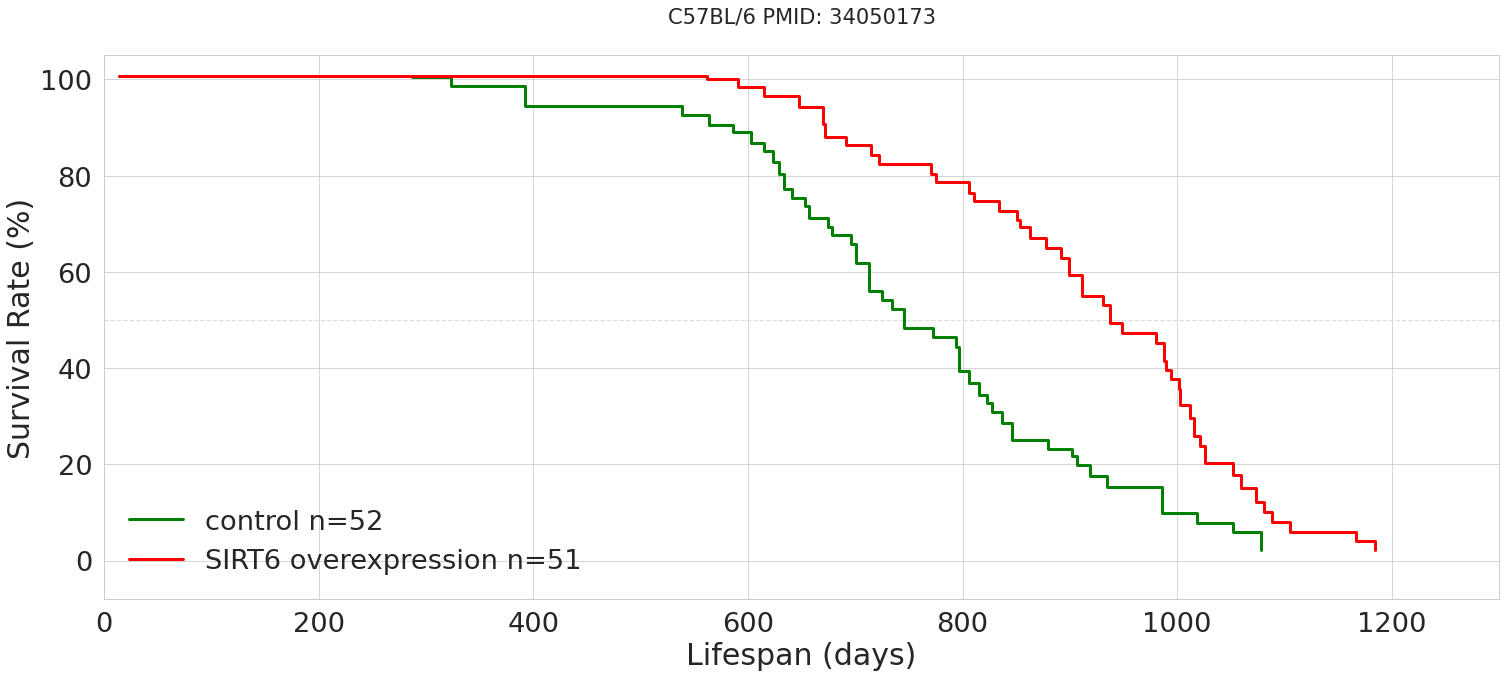

In [38]:
fig, ax = prepare_plot('C57BL/6 PMID: 34050173')

ax= sns.lineplot(data=sirt_control, y='y', x='x', color='g', label= 'control n=52', drawstyle='steps-post', linewidth = 3)
ax1= sns.lineplot(data=sirt_experiment, y='y', x='x', color='r', label= 'SIRT6 overexpression n=51', drawstyle='steps-post', linewidth = 3)

ax.set_xlim(0, 1300)
ax.set_ylim(-8, 105)
plt.legend(loc='lower left')

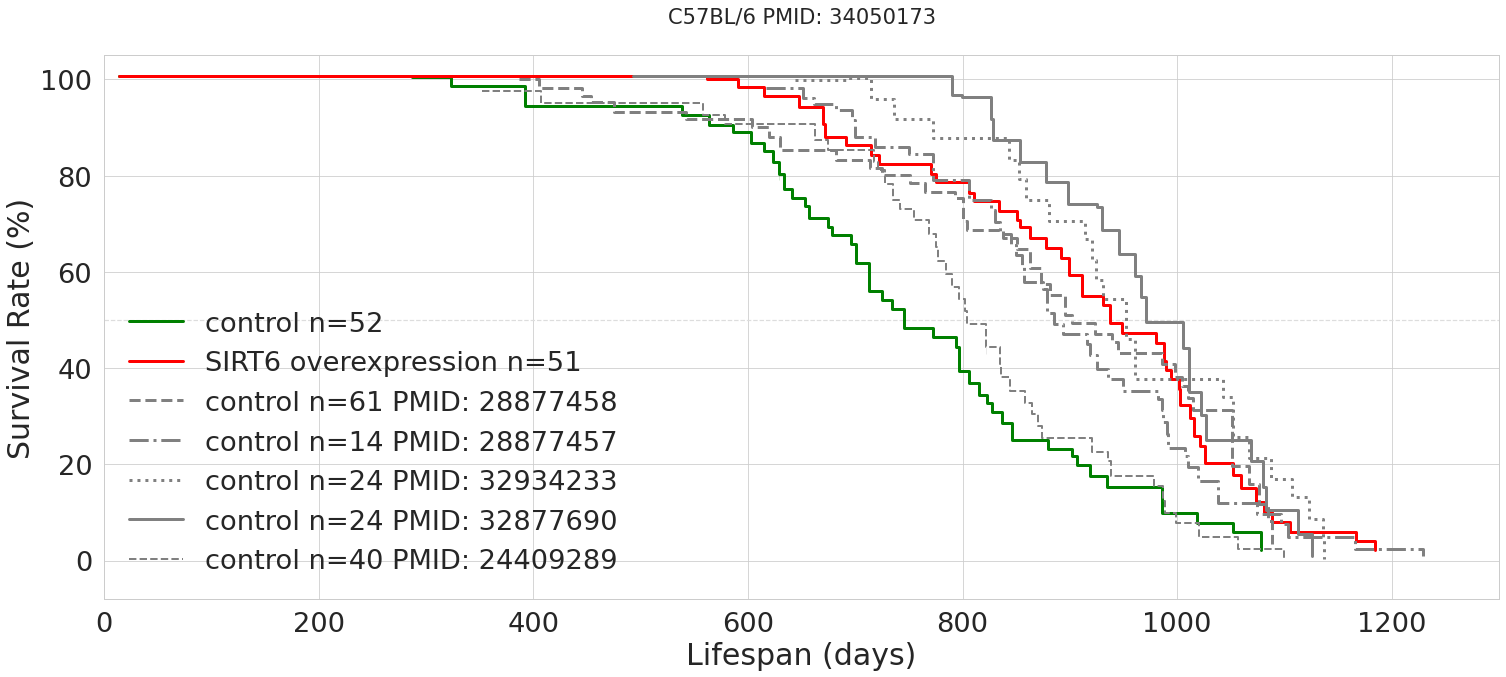

In [39]:
fig, ax = prepare_plot('C57BL/6 PMID: 34050173')

ax= sns.lineplot(data=sirt_control, y='y', x='x', color='g', label= 'control n=52', drawstyle='steps-post', linewidth = 3)
ax1= sns.lineplot(data=sirt_experiment, y='y', x='x', color='r', label= 'SIRT6 overexpression n=51', drawstyle='steps-post', linewidth = 3)

ax2 = sns.lineplot(data=keto_control, y='y', x='x', color='gray', label= 'control n=61 PMID: 28877458', ls='--', drawstyle='steps-post', linewidth = 3)
ax3 = sns.lineplot(data=diet_control, y='y', x='x', color='gray', label= 'control n=14 PMID: 28877457', ls='-.', drawstyle='steps-post', linewidth = 3)
ax4 = sns.lineplot(data=frailty_control, y='y', x='x', color='gray', label= 'control n=24 PMID: 32934233', ls=':', drawstyle='steps-post', linewidth = 3)
ax5 = sns.lineplot(data=akg_control, y='y', x='x', color='gray', label= 'control n=24 PMID: 32877690', drawstyle='steps-post', linewidth = 3)
ax6 = sns.lineplot(data=rapa2_control, y='y', x='x', color='gray', label= 'control n=40 PMID: 24409289', ls='--', drawstyle='steps-post', linewidth = 2)

ax.set_xlim(0, 1300)
ax.set_ylim(-8, 105)
plt.legend(loc='lower left')

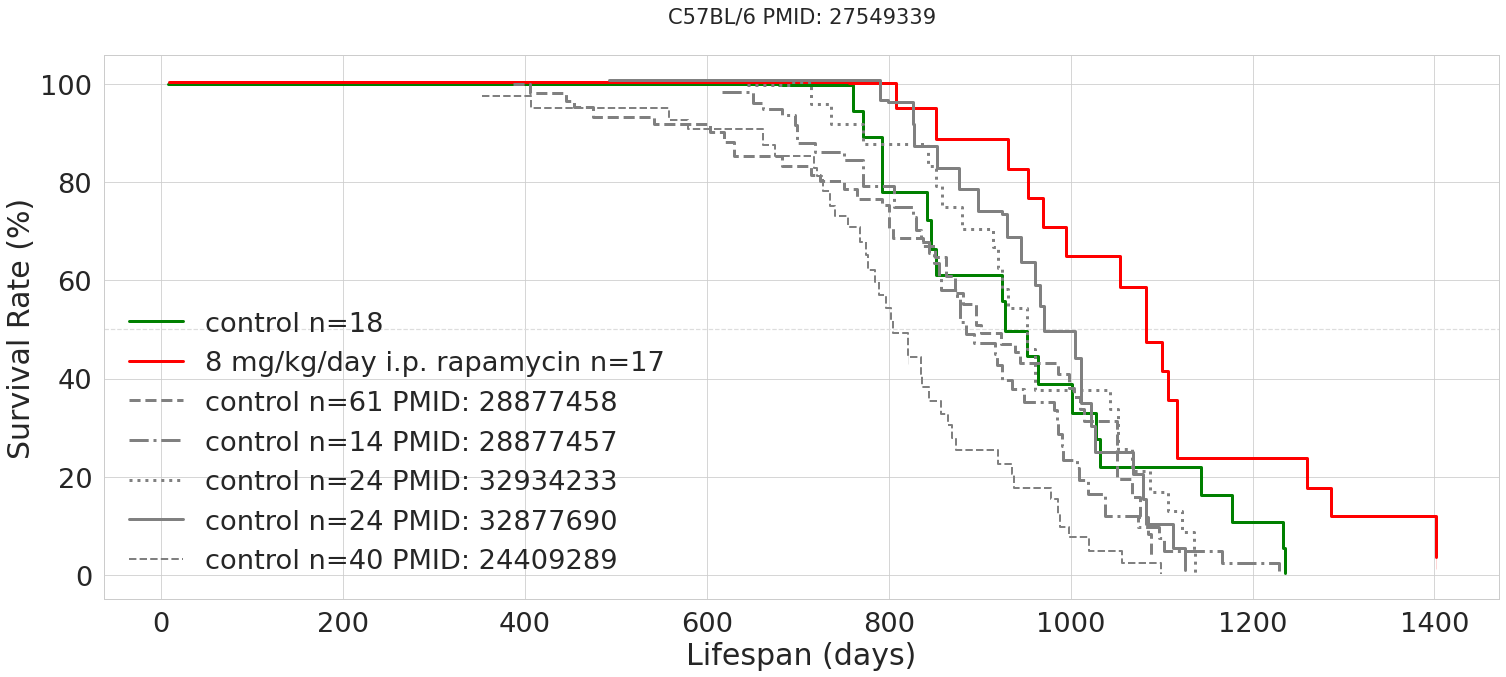

In [40]:
fig, ax = prepare_plot('C57BL/6 PMID: 27549339')

ax= sns.lineplot(data=rapa_control, y='y', x='x', color='g', label= 'control n=18', drawstyle='steps-post', linewidth = 3)
ax1= sns.lineplot(data=rapa_experiment, y='y', x='x', color='r', label= '8 mg/kg/day i.p. rapamycin n=17', drawstyle='steps-post', linewidth = 3)

ax2 = sns.lineplot(data=keto_control, y='y', x='x', color='gray', label= 'control n=61 PMID: 28877458', ls='--', drawstyle='steps-post', linewidth = 3)
ax3 = sns.lineplot(data=diet_control, y='y', x='x', color='gray', label= 'control n=14 PMID: 28877457', ls='-.', drawstyle='steps-post', linewidth = 3)
ax4 = sns.lineplot(data=frailty_control, y='y', x='x', color='gray', label= 'control n=24 PMID: 32934233', ls=':', drawstyle='steps-post', linewidth = 3)
ax5 = sns.lineplot(data=akg_control, y='y', x='x', color='gray', label= 'control n=24 PMID: 32877690', drawstyle='steps-post', linewidth = 3)
ax6 = sns.lineplot(data=rapa2_control, y='y', x='x', color='gray', label= 'control n=40 PMID: 24409289', ls='--', drawstyle='steps-post', linewidth = 2)

## together

['extra control', 'rapamycin control', 'rapamycin', 'berberine control', 'berberine', 'SIRT6 control', 'SIRT6']


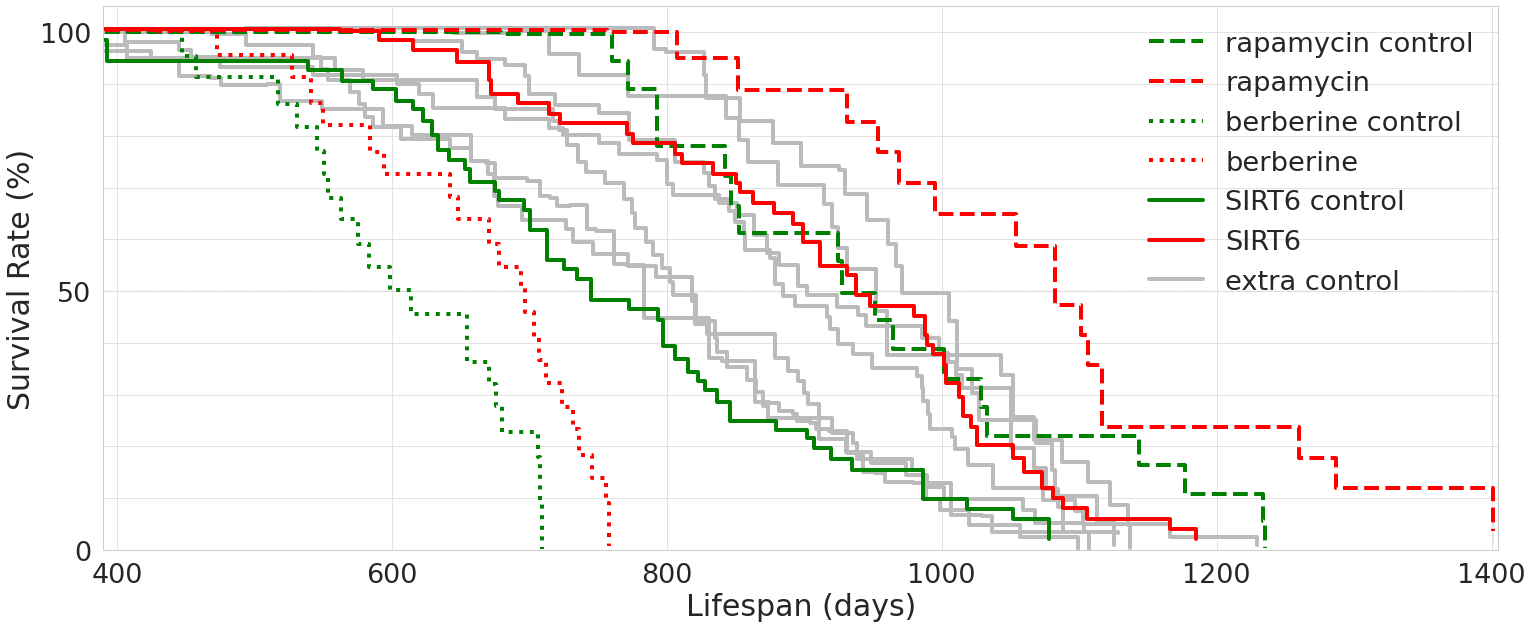

In [41]:


# with sns.axes_style("whitegrid"):
with sns.axes_style("whitegrid", {"grid.color" : "#ddd"}):
  fig, ax = prepare_plot(title='')
  ax.margins(y=-0.004)
  plt.xlim([390, 1405])
  plt.ylim(bottom=90, top=105)
  ax.set_yticks(range(0, 101, 10))
  ax.tick_params(axis='both', which='major', labelsize=27)

  for i in range(4):
    ax.yaxis.get_ticklabels()[1].set_visible(False)
  for i in range(4):
    ax.yaxis.get_ticklabels()[2].set_visible(False)
  

  ax = sns.lineplot(data=keto_control, y='y', x='x', color='#bbb', drawstyle='steps-post', linewidth = 4)         # + label= 'control n=61 PMID: 28877458'
  ax3 = sns.lineplot(data=diet_control, y='y', x='x', color='#bbb', drawstyle='steps-post', linewidth = 4)         # + , label= 'control n=14 PMID: 28877457'
  ax4 = sns.lineplot(data=frailty_control, y='y', x='x', color='#bbb', drawstyle='steps-post', linewidth = 4)       # , label= 'control n=24 PMID: 32934233'
  ax5 = sns.lineplot(data=akg_control, y='y', x='x', color='#bbb', drawstyle='steps-post', linewidth = 4)                   # , label= 'control n=24 PMID: 32877690'
  ax6 = sns.lineplot(data=rapa2_control, y='y', x='x', color='#bbb', drawstyle='steps-post', linewidth = 4)        # , label= 'control n=40 PMID: 24409289'
  ax7 = sns.lineplot(data=circad_control, y='y', x='x', color='#bbb', drawstyle='steps-post', linewidth = 4)                # + , label= 'control n=43 PMID: 35511946'
  ax8 = sns.lineplot(data=chinese_control, y='y', x='x', color='#bbb', label= 'extra control', drawstyle='steps-post', linewidth = 4)               # + control n=54 PMID: 20370440

  ax0= sns.lineplot(data=rapa_control, y='y', x='x', color='g', label= 'rapamycin control', drawstyle='steps-post', ls='--', linewidth = 4)                   # + control n=18
  ax1= sns.lineplot(data=rapa_experiment, y='y', x='x', color='r', label= 'rapamycin', ls='--', drawstyle='steps-post', linewidth = 4)                         # + 8 mg/kg/day i.p. rapamycin n=17
  ax20= sns.lineplot(data=berberine_control, y='y', x='x', color='g', label= 'berberine control', drawstyle='steps-post', ls=':', linewidth = 4)                         # +  control n=22
  ax21= sns.lineplot(data=berberine_experiment, y='y', x='x', color='r', label= 'berberine', ls=':', drawstyle='steps-post', linewidth = 4, ci=95)  # + 50 mg/kg Berberine n=22
  ax10= sns.lineplot(data=sirt_control, y='y', x='x', color='g', label= 'SIRT6 control', drawstyle='steps-post', linewidth = 4)                               # + SIRT6 control n=52
  ax11= sns.lineplot(data=sirt_experiment, y='y', x='x', color='r', label= 'SIRT6', drawstyle='steps-post', linewidth = 4)                    # + SIRT6 overexpression n=51
  # plt.legend(loc='lower left')
  handles, labels = ax.get_legend_handles_labels()
  print(labels)
  order = [1, 2, 3, 4, 5, 6, 0]
  plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order])

  plt.savefig('line_plot.pdf')  


# спасибо .. замечания по картинке. 
# + 1. наверное не надо на главной картинке помечать контроли отдельно, не о них речь идет. 
#     Давайте сделаем две картинки, одну в Supplement где отрисованы "серые контроли контролей" каждый своим цветом или штрихом и помечены PMID. 
# +   А в Этой главной и единственой картинке пометим все их серым одинаково.  Серы если можно потемнее ...  и просто обзовем их "extra control" пока. 
# + 2. не надо начинать Lifespan с Нуля. мертвое пространство на графике. можно где то с 500 (?) дней. 
# + 3. по оси Y сличком много меток и мелковато, важно чтоб был 100%,  50%  и 0%. 
# + 4. количество мышей можно тоже оставить для подписи к картинке, легенду хочу сделать короткую и крупно хорошо видную.  
# 5.  как то я не обращал внимание раньше на ступенку в Рапамицине, и в контролях и в красной ... у нас по этим мышам только одна статья с рапомицином ? как то мало там зверей ... 17 + 18.   Ну если нет больше будем с этими двигаться. 
# + 6. дозу тоже можно оставить для подписи и убрать из легенды.   Может  все что надо в легенде это " + SIRT6, - SIRT6, + barb, - barb, + rapa, - rapa, extras"

In [42]:
#@title Default title text
variable_name = "" #@param {type:"string"}


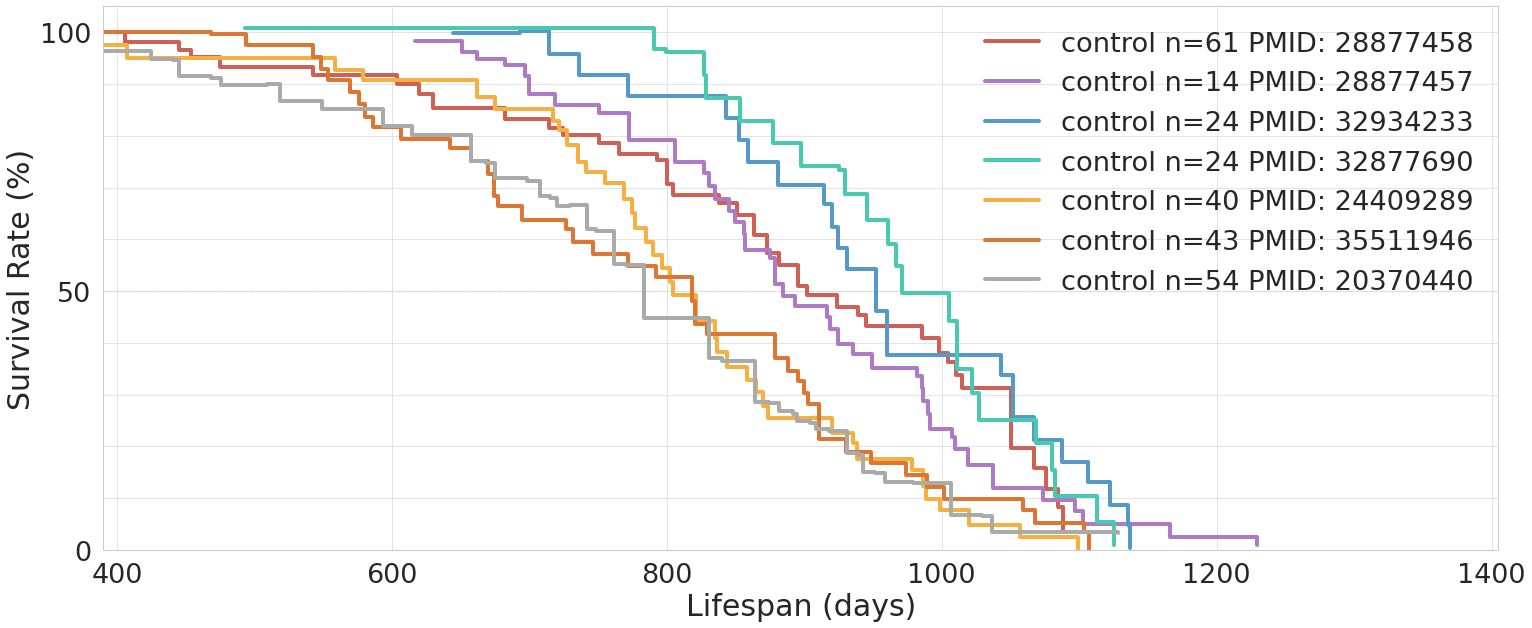

In [43]:


# with sns.axes_style("whitegrid"):
with sns.axes_style("whitegrid", {"grid.color" : "#ddd"}):
  fig, ax = prepare_plot(title='')
  ax.margins(y=-0.004)
  plt.xlim([390, 1405])
  plt.ylim(bottom=90, top=105)
  ax.set_yticks(range(0, 101, 10))
  ax.tick_params(axis='both', which='major', labelsize=27)

  for i in range(4):
    ax.yaxis.get_ticklabels()[1].set_visible(False)
  for i in range(4):
    ax.yaxis.get_ticklabels()[2].set_visible(False)

  ax = sns.lineplot(data=keto_control, y='y', x='x', color='#CD6155', label= 'control n=61 PMID: 28877458', drawstyle='steps-post', linewidth = 4)         # +
  ax3 = sns.lineplot(data=diet_control, y='y', x='x', color='#AF7AC5', label= 'control n=43 PMID: 28877457', drawstyle='steps-post', linewidth = 4)         # +
  ax4 = sns.lineplot(data=frailty_control, y='y', x='x', color='#5499C7', label= 'control n=24 PMID: 32934233', drawstyle='steps-post', linewidth = 4)       # 
  ax5 = sns.lineplot(data=akg_control, y='y', x='x', color='#48C9B0', label= 'control n=24 PMID: 32877690', drawstyle='steps-post', linewidth = 4)                   # 
  ax6 = sns.lineplot(data=rapa2_control, y='y', x='x', color='#F5B041', label= 'control n=40 PMID: 24409289', drawstyle='steps-post', linewidth = 4)        # 
  ax7 = sns.lineplot(data=circad_control, y='y', x='x', color='#DC7633', label= 'control n=43 PMID: 35511946', drawstyle='steps-post', linewidth = 4)                # +
  ax8 = sns.lineplot(data=chinese_control, y='y', x='x', color='#aaa', label= 'control n=54 PMID: 20370440', drawstyle='steps-post', linewidth = 4)               # +


# спасибо .. замечания по картинке. 
# + 1. наверное не надо на главной картинке помечать контроли отдельно, не о них речь идет. 
# +    Давайте сделаем две картинки, одну в Supplement где отрисованы "серые контроли контролей" каждый своим цветом или штрихом и помечены PMID. 
# +    А в Этой главной и единственой картинке пометим все их серым одинаково.  Серы если можно потемнее ...  и просто обзовем их "extra control" пока. 
# + 2. не надо начинать Lifespan с Нуля. мертвое пространство на графике. можно где то с 500 (?) дней. 
# 3. по оси Y сличком много меток и мелковато, важно чтоб был 100%,  50%  и 0%. 
# 4. количество мышей можно тоже оставить для подписи к картинке, легенду хочу сделать короткую и крупно хорошо видную.  
# 5.  как то я не обращал внимание раньше на ступенку в Рапамицине, и в контролях и в красной ... у нас по этим мышам только одна статья с рапомицином ? как то мало там зверей ... 17 + 18.   Ну если нет больше будем с этими двигаться. 
# 6. дозу тоже можно оставить для подписи и убрать из легенды.   Может  все что надо в легенде это " + SIRT6, - SIRT6, + barb, - barb, + rapa, - rapa, extras"